In [1]:
%load_ext autoreload
%autoreload 2

# Formatting your data: feature extraction from motion tracking output

##### What we'll cover:
    
* Create and run a project.
* Load a previously generated project.
* Interact with your project: generate coordinates, distances, angles, and areas.
* Exploratory visualizations: heatmaps and processed animations.

Let's start by importing some packages. We'll use python's os library to handle paths, pickle to load saved objects, and the data entry API within DeepOF, located in deepof.data

In [2]:
import os
import pickle
import deepof.data

We'll also need some plotting gear:

In [3]:
import deepof.visuals
import matplotlib.pyplot as plt
import seaborn as sns

### Creating and running a project

With that out of the way, the first thing to do when starting a DeepOF project is to load your videos and DeepLabCut tracking files into a deepof.data.Project object. 

Like depicted in the cell below, the three crucial parameters to input are the project, video and tab paths. 

* project_path specifies where the project folder containing all processing and output files will be created.
* video_path points towards where your DLC labeled videos are stored
* similarly, table_path shoult point to the directory containing all tracking files (in either csv or h5 format)
* last but not least, you can give your project a name (optional; deepof_project by default).

The dataset used in this tutorial is a subset of the social interaction (SI) dataset used in DeepOF's original paper. It contains six 10-minute-long videos with two animals (a C57Bl6 and a CD1) tracked in a round arena. Three of the C57Bl6 mice have been exposed to chronic social defeat stress (CSDS).

In [4]:
# my_deepof_project = deepof.data.Project(
#                 project_path=os.path.join("tutorial_files"),
#                 video_path=os.path.join("tutorial_files/Videos/"),
#                 table_path=os.path.join("tutorial_files/Tables/"),
#                 project_name="tutorial_project",
#                 arena="circular-manual",
#                 animal_ids=["B", "W"],
#                 video_format=".mp4",
#                 exclude_bodyparts=["Tail_1", "Tail_2", "Tail_tip"],
#                 video_scale=380,
#                 enable_iterative_imputation=10,
#                 smooth_alpha=1,
#                 exp_conditions=None,
# )

As you may see, there are some extra (optional) parameters in the call above. These specify some details on how the videos and tracks will be processed. Some include:

* arena: some functions within DeepOF (as you will see in the next tutorial on supervised annotations) require the program to detect the arena. This can be either done automatically in some settings (round arenas, with strong contrast between bedding and the outside, like in the tutorial videos). However, we recommend doing it manually to add precision and flexibility (see GUI below). Can be set to circular-autodetect, circular-manual, or polygonal-manual.
* animal_ids: in case more than one animal is present in the dataset, the IDs assigned to each during DLC tracking need to be specified as a list.
* exclude_body_parts: while DeepOF originally relies on 14 body part tracking models, body parts along the tail are no longer used. This step could be bypassed using smaller models following an 11-body-part scheme, such as the one presented in the landing page of the documentation.
* video_scale: diameter of the arena (in mm) if circular. In the case of polygonal arenas, the length (in mm) of the first edge as specified in the GUI (see below) should be provided.
* enable_iterative_imputation: maximum number of iterations of the iterative imputation step, which aims to recover the position of occluded body parts. Higher numbers will increase precision, but also computation time, especially in multi-animal settings.
* smooth_alpha: smoothing intensity. The higher the value, the more smoothing is applied.
* exp_conditions: dictionary with a video IDs as keys, and data frames with all experimental conditions as values. DeepOF will use this information to enable all sorts of comparisons between conditions, as we will see in the following tutorials. We'll leave it blank for now and update it afterwards.

For more details, feel free to visit the full API reference.

Let's then create our first project, by running the .create() method in our newly created object:

In [5]:
# my_deepof_project = my_deepof_project.create()

As you will see, this organizes all required file into a folder in the specified path. Moreover, some processing steps are computed on the go, such as distances, angles and areas. This makes it easier for DeepOF to load all required features later on, without the need to compute them every time.

In addition, if "circular-manual" or "polygonal-manual" were selected in the 'arena' parameter, a GUI will pop up in the "detecting arena" step.

![arena_GUI](./tutorial_files/Assets/arena_GUI.png)

A window per video will appear, and allow you to manually mark where the arena is with just a few clicks. All results will be stored for further processing. 

Clicking anywhere in the video will make an orange marker appear. In the case of polygonal arenas, at least a marker per corner should be used. When dealing with circular (or elliptical) arenas, DeepOF will fit an ellipse to the marked points after a minimum of 5 clicks. The ellipse can always be refined by adding more markers. Once finished with a video, press 'q' to save and move to the next one. If you made a mistake and would like to correct it, press 'd' to delete the last added marker.

**NOTE**: in polygonal arenas, the first edge you input will be used to scale the coordinates to the proper distances (pixels to millimeters). Make sure you always mark the same edge first, and that it coincides with the length passed to the "video_scale" parameter when creating the project.

**NOTE2**: currently, area computation works on a single core, and can take some time for large datasets. We're working on making it faster, but for now, know you only need to run it once! We cover how to load previously created projects right afterwards.

### Loading a previously generated project

Once you ran your project at least once, it can be loaded without much effort from the path you specified in the first place (plus the project name -deepof_project, if you didn't specify otherwise-).

In [6]:
# Load a previously saved project
my_deepof_project = deepof.data.load_project("./tutorial_files/tutorial_project/")

### Interacting with your project: generating coordinates, distances, angles, and areas.

That's it for basic project creation. We now have a DeepOF project up and running! Before ending the tutorial, however, let's explore the object that the commands above produced.

For starters, if we print it, we see it's a DeepOF analysis of 6 videos. Furthermore, the object belongs to a custom class within DeepOF, called Coordinates. This class allows the package to store all sorts of relevant information required for further processing, as we'll see below:

In [7]:
print(my_deepof_project)
print(type(my_deepof_project))

deepof analysis of 6 videos
<class 'deepof.data.Coordinates'>


As described before, the .create() method runs most of the heavy preprocessing already, which allows us to extract features including coordinates, distances, angles, and areas. Let's see how that works!

![preprocessing](./tutorial_files/Assets/deepof_preprocessing.png)

With the .get_coords() method, for example, we can obtain the processed (smooth and imputed) tracks for all videos in a dictionary. The returned objects are called table dictionaries (TableDict is the name of the class). They follow a dictionary-like structure, where each value is a data frame. They also provide a plethora of extra methods, some of which we'll cover in these tutorials. Let's retrieve these for one of the animals:

In [8]:
my_deepof_project.get_coords(polar=False, center="Center", align="Spine_1")['20191204_Day2_SI_JB08_Test_54']

B_Spine_1            B_Center      B_Left_bhip             \
                           x          y        x    y           x          y   
00:00:00                 0.0  17.041283      0.0  0.0   16.235626  -9.286406   
00:00:00.039935995       0.0  16.475167      0.0  0.0   15.143549 -10.150172   
00:00:00.079871991       0.0  16.446049      0.0  0.0   11.477393 -12.396184   
00:00:00.119807987       0.0  15.217471      0.0  0.0   10.208930 -14.160422   
00:00:00.159743982       0.0  15.037661      0.0  0.0   10.836279 -15.220016   
...                      ...        ...      ...  ...         ...        ...   
00:09:58.800320021       0.0  17.383252      0.0  0.0   15.964064 -11.925356   
00:09:58.840256017       0.0  15.069470      0.0  0.0   15.782188 -13.477302   
00:09:58.880192012       0.0  19.435457      0.0  0.0   12.847697 -11.565332   
00:09:58.920128008       0.0  19.435457      0.0  0.0   12.847697 -11.565332   
00:09:58.960064004       0.0  19.435457      0.0  0.0   12.847697 -11.565332   

                   B_Left_ear            B_Left_fhip             ...  \
                            x          y           x          y  ...   
00:00:00             2.338149  35.826017   14.520708  16.191088  ...   
00:00:00.039935995   0.671672  35.836244   14.183559  14.703795  ...   
00:00:00.079871991   0.097058  35.005123   13.716176  13.898245  ...   
00:00:00.119807987  -0.358944  35.315238   15.230370  11.435026  ...   
00:00:00.159743982   0.861588  34.324995   14.984768  10.471671  ...   
...                       ...        ...         ...        ...  ...   
00:09:58.800320021  10.656661  35.405103   14.810418  11.274649  ...   
00:09:58.840256017   7.241669  39.238723   14.817890   9.091584  ...   
00:09:58.880192012   7.622541  42.242592   14.851511  12.187561  ...   
00:09:58.920128008   7.622541  42.242592   14.851511  12.187561  ...   
00:09:58.960064004   7.622541  42.242592   14.851511  12.187561  ...   

                   W_Right_bhip            W_Right_ear             \
                              x          y           x          y   
00:00:00             -11.115287 -13.877286  -11.056773  52.165913   
00:00:00.039935995   -13.884385 -18.083860  -11.634608  53.793769   
00:00:00.079871991   -15.550991 -13.873025  -12.439161  53.259569   
00:00:00.119807987   -14.469009 -16.138564  -11.961743  52.265874   
00:00:00.159743982   -14.028915 -18.169221  -19.961073  49.485545   
...                         ...        ...         ...        ...   
00:09:58.800320021   -20.815692  -6.861448  -17.302919  31.105013   
00:09:58.840256017   -20.930728  -7.043085  -17.317452  31.011691   
00:09:58.880192012   -20.912197  -7.052485  -17.362287  30.948820   
00:09:58.920128008   -20.912197  -7.052485  -17.362287  30.948820   
00:09:58.960064004   -20.912197  -7.052485  -17.362287  30.948820   

                   W_Right_fhip            W_Spine_2            W_Tail_base  \
                              x          y         x          y           x   
00:00:00             -10.837443  11.900607  1.303025 -19.189055   -9.987794   
00:00:00.039935995   -13.457341  12.356739  1.828954 -24.439299   -1.620732   
00:00:00.079871991   -14.284002  12.808460  0.793345 -21.164099    1.765989   
00:00:00.119807987   -14.571504  13.210702  1.309584 -22.165508    2.815459   
00:00:00.159743982   -14.900604  11.323389  1.955114 -22.447853    2.289354   
...                         ...        ...       ...        ...         ...   
00:09:58.800320021   -12.210518  10.521213 -6.286187 -15.291244  -18.448989   
00:09:58.840256017   -12.259446  10.426808 -6.220324 -15.480332  -18.379192   
00:09:58.880192012   -12.239039  10.390575 -6.179682 -15.503151  -18.331690   
00:09:58.920128008   -12.239039  10.390575 -6.179682 -15.503151  -18.331690   
00:09:58.960064004   -12.239039  10.390575 -6.179682 -15.503151  -18.331690   

                               
                            y  
00:00:00           -46.786090  
00:00:00.039935995 

Note that there are a few parameters you can pass to the .get_coords() method. If "polar" is set to True, polar coordinates will be used, instead of Cartesian. Both "center" and "align" control how translational and rotational variance are removed from the data: the former will use the specified body part as [0, 0] (or the center of the arena, if set to "arena"). The latter will rotate the mice on each time point, to align the line connecting the body parts specified in the "center" and "align" methods with the y-axis.

Furthermore, not only processed coordinates can be retrieved, but also distances, angles, and areas with the .get_distances(), .get_angles(), and .get_areas(), respectively.

In [9]:
my_deepof_project.get_distances()['20191204_Day2_SI_JB08_Test_54']

,"(W_Center, W_Spine_2)","(W_Center, W_Spine_1)","(B_Nose, W_Tail_base)","(W_Center, W_Right_fhip)","(W_Spine_2, W_Tail_base)","(B_Spine_2, B_Tail_base)","(B_Center, B_Left_fhip)","(W_Left_ear, W_Nose)","(W_Left_ear, W_Spine_1)","(B_Right_ear, B_Spine_1)",...,"(W_Left_bhip, W_Spine_2)","(W_Right_ear, W_Spine_1)","(B_Tail_base, W_Tail_base)","(B_Center, B_Spine_2)","(W_Right_bhip, W_Spine_2)","(B_Right_bhip, B_Spine_2)","(B_Left_bhip, B_Spine_2)","(B_Left_ear, B_Spine_1)","(B_Nose, W_Nose)","(W_Nose, W_Right_ear)"
00:00:00,15.650178,20.063313,115.579049,13.097221,24.262574,14.630636,17.696946,18.915606,27.171833,14.300370,...,12.385698,24.124739,98.128243,13.459102,10.990415,11.352427,15.294229,15.403174,198.053922,22.932418
00:00:00.039935995,19.941976,21.979316,118.523850,14.866295,19.983948,14.515957,16.623784,19.199412,25.867469,14.756100,...,15.770459,23.760425,103.329454,13.773171,13.792246,11.621177,15.264173,15.763673,202.762435,21.945866
00:00:00.079871991,17.233418,20.005466,123.177995,15.611454,16.667571,14.816680,15.889020,22.317250,27.690706,14.490980,...,14.512332,25.432991,112.995114,13.896078,14.562744,11.461481,14.663255,15.101808,203.411343,24.897477
00:00:00.119807987,18.067626,20.297740,122.999419,16.004378,16.546259,16.005507,15.497258,21.072843,29.150648,15.648562,...,15.156571,24.268611,120.138537,14.175288,13.743853,12.029250,14.804978,16.356251,202.302336,24.811224
00:00:00.159743982,18.335068,21.108747,122.297162,15.228391,17.880008,15.589586,14.875425,21.258547,26.537352,16.058247,...,15.140400,25.116524,123.879733,13.787522,13.464188,12.912796,15.041685,15.709842,201.555974,22.888286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:09:58.800320021,13.452932,15.193842,192.208726,13.115358,13.580543,14.777048,15.145972,23.578072,18.947365,17.047292,...,15.959499,17.337064,232.725078,16.948890,13.668491,13.705981,13.848864,17.036406,148.947746,19.360373
00:09:58.840256017,13.575291,15.144409,187.529354,13.095647,13.570579,14.639053,14.145984,23.603226,18.991163,17.452928,...,15.970098,17.331226,229.550823,19.694996,13.799025,13.381874,13.526511,20.530436,145.290080,19.405286
00:09:58.880192012,13.580242,15.172837,186.805039,13.063902,13.587918,15.440113,15.632956,23.564206,19.010041,18.024676,...,16.005486,17.314768,227.365469,17.733240,13.820064,13.731724,13.801566,19.567327,147.479959,19.419134
00:09:58.920128008,13.580242,15.172837,186.805039,13.063902,13.587918,15.440113,15.632956,23.564206,19.010041,18.024676,...,16.005486,17.314768,227.365469,17.733240,13.820064,13.731724,13.801566,19.567327,147.479959,19.419134


In [10]:
my_deepof_project.get_angles()['20191204_Day2_SI_JB08_Test_54']

,"(B_Right_ear, B_Nose, B_Left_ear)","(B_Spine_1, B_Center, B_Right_fhip)","(B_Spine_1, B_Center, B_Spine_2)","(B_Spine_1, B_Center, B_Left_fhip)","(B_Right_fhip, B_Center, B_Spine_2)","(B_Right_fhip, B_Center, B_Left_fhip)","(B_Spine_2, B_Center, B_Left_fhip)","(B_Nose, B_Right_ear, B_Spine_1)","(B_Center, B_Spine_1, B_Right_ear)","(B_Center, B_Spine_1, B_Left_ear)",...,"(W_Center, W_Spine_1, W_Right_ear)","(W_Center, W_Spine_1, W_Left_ear)","(W_Right_ear, W_Spine_1, W_Left_ear)","(W_Nose, W_Left_ear, W_Spine_1)","(W_Right_bhip, W_Spine_2, W_Center)","(W_Right_bhip, W_Spine_2, W_Left_bhip)","(W_Right_bhip, W_Spine_2, W_Tail_base)","(W_Center, W_Spine_2, W_Left_bhip)","(W_Center, W_Spine_2, W_Tail_base)","(W_Left_bhip, W_Spine_2, W_Tail_base)"
00:00:00,1.160113,1.377328,1.651250,1.214725,1.805680,1.281616,0.880634,1.432043,1.196342,1.011682,...,1.018039,1.087471,1.217084,1.281608,0.907083,0.957481,0.866423,0.999432,0.905761,0.884871
00:00:00.039935995,1.432389,1.185691,1.228362,1.160516,1.370046,1.299858,1.502996,1.322836,1.363091,1.351738,...,1.044152,1.148573,1.133904,1.240229,0.875619,0.926542,0.829069,1.004840,0.919997,0.966073
00:00:00.079871991,1.216272,1.511253,1.159734,1.264802,1.190446,1.295514,1.331724,1.192038,1.463842,1.366577,...,1.133077,1.152785,1.129943,1.141603,0.858561,0.840083,0.740774,0.937553,0.838244,0.900188
00:00:00.119807987,1.173849,1.406159,1.618816,1.216881,1.765511,1.277808,0.915767,1.470723,1.226859,1.040176,...,1.039895,1.115584,1.256596,1.318291,0.933607,0.980755,0.882201,1.033831,0.931403,0.910080
00:00:00.159743982,1.447212,1.190478,1.229561,1.162294,1.356475,1.286804,1.450061,1.327486,1.344254,1.325993,...,1.079375,1.189133,1.170519,1.275993,0.886386,0.941864,0.854115,1.030953,0.953687,0.988059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:09:58.800320021,1.157507,0.893153,0.820365,0.791607,0.859565,0.832034,0.753215,1.138762,0.947757,0.855670,...,0.071047,0.077788,0.026153,0.100734,0.123158,0.127283,0.152219,0.023098,0.036456,0.016655
00:09:58.840256017,1.174168,0.892060,0.740130,0.818470,0.779166,0.870837,0.793762,0.974592,1.021022,0.993133,...,0.121503,0.062928,0.048816,0.067761,0.117070,0.029155,0.140526,0.015894,0.116224,0.107108
00:09:58.880192012,1.078723,0.951965,0.867792,0.859339,0.861663,0.853209,0.707809,1.224486,0.905549,0.875838,...,0.090246,0.132222,0.014020,0.197988,0.114509,0.097007,0.247217,0.023890,0.174100,0.078203
00:09:58.920128008,1.170956,0.903225,0.829609,0.800677,0.861166,0.833963,0.749906,1.166492,0.952019,0.859763,...,0.063343,0.069335,0.046125,0.113071,0.114700,0.115985,0.141577,0.013881,0.026288,0.011959


In [11]:
my_deepof_project.get_areas()['20191204_Day2_SI_JB08_Test_54']

,B_head_area,B_torso_area,B_back_area,B_full_area,W_head_area,W_torso_area,W_back_area,W_full_area
00:00:00,287.018462,467.472460,513.431000,1697.086099,588.316685,575.287843,557.837678,2402.446220
00:00:00.039935995,298.006089,461.593907,511.611552,1664.187297,532.941463,711.610814,747.171324,2612.577515
00:00:00.079871991,283.907493,436.994147,491.022208,1571.659017,615.224965,659.274363,696.773878,2680.819039
00:00:00.119807987,336.017364,459.434553,495.609970,1674.157290,664.955274,698.278394,709.587295,2725.074795
00:00:00.159743982,338.565821,456.785954,510.514167,1706.762126,589.501549,713.393985,706.975280,2732.936140
...,...,...,...,...,...,...,...,...
00:09:58.800320021,364.598702,512.092068,562.957165,1882.932433,516.368794,466.566421,607.161201,1974.352930
00:09:58.840256017,342.771541,514.231920,543.299019,1832.083470,517.334943,468.582411,611.765902,1979.455000
00:09:58.880192012,388.332158,529.127829,558.340318,1889.399535,516.875687,468.401897,613.444346,1980.834529
00:09:58.920128008,388.332158,529.127829,558.340318,1889.399535,516.875687,468.401897,613.444346,1980.834529


Last but not least, features can be merged using the .merge() method, which can yield combinations of features if needed. For example, the code in the following cell creates an object with both coordinates and areas per time point:

In [12]:
my_deepof_project.get_coords().merge(my_deepof_project.get_areas())['20191204_Day2_SI_JB08_Test_54']

,"(B_Center, x)","(B_Center, y)","(B_Left_bhip, x)","(B_Left_bhip, y)","(B_Left_ear, x)","(B_Left_ear, y)","(B_Left_fhip, x)","(B_Left_fhip, y)","(B_Nose, x)","(B_Nose, y)",...,"(W_Tail_base, x)","(W_Tail_base, y)",B_head_area,B_torso_area,B_back_area,B_full_area,W_head_area,W_torso_area,W_back_area,W_full_area
00:00:00,223.193283,184.124115,222.160935,202.799423,191.852982,166.609666,201.709718,187.509186,188.298004,147.322081,...,321.353759,97.605996,287.018462,467.472460,513.431000,1697.086099,588.316685,575.287843,557.837678,2402.446220
00:00:00.039935995,222.081848,185.302109,221.340759,203.517593,192.753159,164.698335,201.841401,188.076859,194.544312,145.935454,...,332.379546,98.838112,298.006089,461.593907,511.611552,1664.187297,532.941463,711.610814,747.171324,2612.577515
00:00:00.079871991,220.547333,186.246719,219.854218,203.126160,197.765198,159.669617,201.092896,184.567551,205.235306,142.500976,...,350.856689,101.147659,283.907493,436.994147,491.022208,1571.659017,615.224965,659.274363,696.773878,2680.819039
00:00:00.119807987,218.467209,184.700256,216.118439,201.998322,202.173355,153.366486,199.648239,181.772736,214.989639,138.281066,...,361.710663,101.918587,336.017364,459.434553,495.609970,1674.157290,664.955274,698.278394,709.587295,2725.074795
00:00:00.159743982,219.402542,182.458069,214.480026,200.481461,206.756088,150.536057,201.725708,177.796661,221.262161,133.663879,...,369.073914,106.446114,338.565821,456.785954,510.514167,1706.762126,589.501549,713.393985,706.975280,2732.936140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:09:58.800320021,108.366647,302.971861,127.398353,297.067658,106.577644,339.902678,118.557281,318.548034,91.342528,360.831938,...,267.896393,517.758606,364.598702,512.092068,562.957165,1882.932433,516.368794,466.566421,607.161201,1974.352930
00:09:58.840256017,108.605596,310.532362,127.530082,302.013032,104.571034,350.229231,120.285217,323.409210,93.433890,367.135740,...,267.855316,517.770020,342.771541,514.231920,543.299019,1832.083470,517.334943,468.582411,611.765902,1979.455000
00:09:58.880192012,108.844546,318.092862,124.715041,311.241029,102.564423,360.555784,119.021164,334.388275,86.603620,377.042506,...,267.961975,517.801758,388.332158,529.127829,558.340318,1889.399535,516.875687,468.401897,613.444346,1980.834529
00:09:58.920128008,108.844546,318.092862,124.715041,311.241029,102.564423,360.555784,119.021164,334.388275,86.603620,377.042506,...,267.961975,517.801758,388.332158,529.127829,558.340318,1889.399535,516.875687,468.401897,613.444346,1980.834529


### Loading experimental conditions

So far, DeepOF does not know to which condition each animal belongs. This can be either set up at project creation (as described above) or specified afterward.

To simplify things, here we'll load an already created object and explain how it works after loading it.

In [13]:
with open("./tutorial_files/tutorial_project/Coordinates/deepof_tutorial_exp_conds.pkl", "rb") as handle:
    exp_conds = pickle.load(handle)
    
my_deepof_project._exp_conditions = exp_conds

By setting the _exp_conditions attribute in the Coordinates object, we can now have access to experimental information on the provided mice. Let's explore what's in there with the .get_exp_conditions property:

In [14]:
print(my_deepof_project.get_exp_conditions)

{'20191204_Day2_SI_JB08_Test_54':           CSDS
0  Nonstressed, '20191204_Day2_SI_JB08_Test_56':        CSDS
0  Stressed, '20191204_Day2_SI_JB08_Test_61':        CSDS
0  Stressed, '20191204_Day2_SI_JB08_Test_62':        CSDS
0  Stressed, '20191204_Day2_SI_JB08_Test_63':           CSDS
0  Nonstressed, '20191204_Day2_SI_JB08_Test_64':           CSDS
0  Nonstressed}


Note that each value is a data frame with a single row, where each column refers to an experimental trait. Adding more columns would allow DeepOF to compare more metadata on the animals (such as sex, strain, etc.).

In [15]:
my_deepof_project.get_exp_conditions['20191204_Day2_SI_JB08_Test_54']

,CSDS
0,Nonstressed


We can see that, as previously mentioned, there's a dictionary with all animal experiments as keys, and data frames with conditions as values. In this case we only have the CSDS condition, which can take two values ("Nonstressed" and "Stressed"). We also see there are exactly three animals per condition.

Now that we have a basic understanding of how to create and interact with a project, let's show some plots!

### Basic visual exploration

Let's first see some basic heatmaps per condition. All plotting functions within DeepOF are hosted in the deepof.visuals module. Among many other things, we can plot average heatmaps per experimental condition! Let's see if we can visualize ant interesting patterns on the available data:

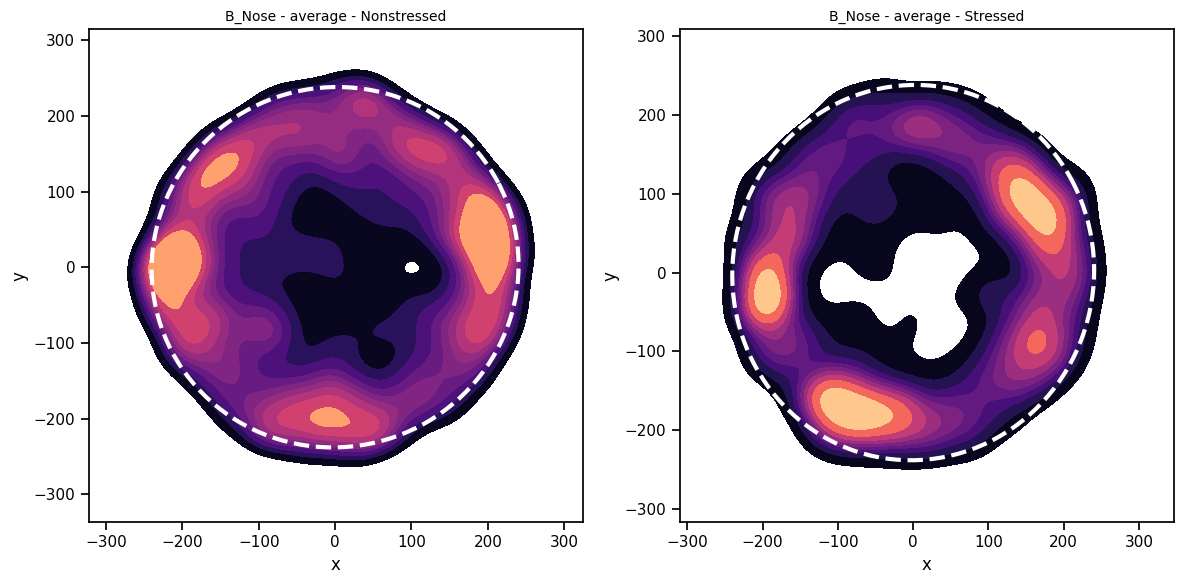

In [16]:
sns.set_context("notebook")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

deepof.visuals.plot_heatmaps(
    my_deepof_project, 
    ["B_Nose"],
    center="arena", 
    exp_condition="CSDS",
    condition_value="Nonstressed",
    ax=ax1,
    show=False,
    display_arena=True,
    experiment_id="average",
)

deepof.visuals.plot_heatmaps(
    my_deepof_project,
    ["B_Nose"],
    center="arena", 
    exp_condition="CSDS",
    condition_value="Stressed",
    ax=ax2,
    show=False,
    display_arena=True,
    experiment_id="average",
)

plt.tight_layout()
plt.show()

It seems stressed animals spend more time closer to the walls of the arena, and less time in the center! For details on how deepof.visuals.plot_heatmap() works, feel free to check the full API reference or the function docstring.

Finally, let's create an animated video showing our newly preprocessed data. DeepOF can produce reconstructions of the tracks and show them as videos. All animals and the arena are displayed by default. This is particularly useful when interpreting clusters and visualizing embeddings in the unsupervised pipeline, as we'll see in a later turorial.

In [17]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    experiment_id="20191204_Day2_SI_JB08_Test_54",
    frame_limit=500,
    dpi=60,
)

html = display.HTML(video)
display.display(html)
plt.close()

### What's next

That's it for this tutorial. Next, we'll see how to run a supervised annotation pipeline with pretrained models!